# 🌊 Estimate wave–ice attenuation rates from MOM–CICE–WW3 output

In [1]:
import intake
from intake import cat
# from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import seaborn as sns
from cycler import cycler

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

# Use Seaborn's colorblind-safe palette
colors = sns.color_palette("colorblind")
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
sns.set_style("ticks")

𝜋 = np.pi
PUNY = 1e-11

Functions from get_files.py imported!


In [2]:
from access_nri_intake.source import builders

builders.__all__

['AccessOm2Builder',
 'AccessOm3Builder',
 'Mom6Builder',
 'AccessEsm15Builder',
 'AccessCm2Builder',
 'ROMSBuilder',
 'WoaBuilder']

In [10]:
%%time
model = "access-om3"
ATTEN_OPT = "IC4M2"
EXPT = f"IC4-{ATTEN_OPT}-MCW_100km_jra_iaf-update" #"IC4-IC4M2-MCW_100km_jra_iaf-test"
drive = "scratch" # or g/data
run_dir = "archive"
PATH = f"/{drive}/ps29/nd0349/access-om3/{run_dir}/{EXPT}" #Some example ACCESS-OM2 output

datastore_name = f"datastore_{model}_{EXPT}"
if not os.path.exists(datastore_name):
    # start = time.time()
    
    builder = builders.AccessOm3Builder(path=PATH).build()
    builder.save(
        name=datastore_name, 
        description="An example datastore for ACCESS-OM3",
    )
    
    # elapsed = time.time() - start
    # print(f"✅ Datastore built in {elapsed:.2f} seconds.")
else:
    print(f"ℹ️ Datastore {datastore_name} already exists — skipping build.")

    
# builder = builders.AccessOm3Builder(path=PATH).build()

Successfully wrote ESM catalog json file to: file:///home/566/nd0349/datastore_access-om3_IC4-IC4M2-MCW_100km_jra_iaf-update.json
CPU times: user 8.77 s, sys: 6.84 s, total: 15.6 s
Wall time: 1min 2s


In [4]:
# builder.save(
#     name=EXPT, 
#     description="An example datastore for ACCESS-OM3",
# )

In [5]:
# EXPT

In [11]:
client = Client(threads_per_worker=1, memory_limit=0)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37877 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37877/status,
Dashboard: /proxy/37877/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44139,Workers: 0
Dashboard: /proxy/37877/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42029,Total threads: 1
Dashboard: /proxy/44055/status,Memory: 0 B
Nanny: tcp://127.0.0.1:41651,


In [12]:

esm_datastore = intake.open_esm_datastore(
    f"./{EXPT}.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,845
path,857
file_id,8
frequency,3
start_date,583
end_date,581
variable,240
variable_long_name,212
variable_standard_name,41
variable_cell_methods,28


In [13]:
esm_datastore_filtered = esm_datastore.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered

,unique
filename,396
path,396
file_id,2
frequency,2
start_date,396
end_date,396
variable,34
variable_long_name,34
variable_standard_name,1
variable_cell_methods,2


In [14]:
# List the datasets
# esm_datastore_filtered.df
len(esm_datastore.df['file_id'].unique())

8

In [15]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
# var = 'aice'
# For example, pick the first file_id
first_file_id = esm_datastore.df['file_id'].unique()[0]

ds_cice = esm_datastore_filtered.search(file_id=first_file_id).to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
ds_cice["time"] = ds_cice.time.to_pandas() - timedelta(hours=12)
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])
ds_cice

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


CPU times: user 26.5 s, sys: 8.14 s, total: 34.7 s
Wall time: 46.8 s


<xarray.Dataset> Size: 48GB
Dimensions:      (time: 365, nkice: 4, nksnow: 1, nkbio: 3, nkaer: 5, nj: 300,
                  ni: 360, nf: 12, nc: 5, nbnd: 2)
Coordinates:
  * time         (time) datetime64[ns] 3kB 1958-01-01 1958-01-02 ... 1958-12-31
    time_bounds  (time, nbnd) datetime64[ns] 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    NCAT         (nc) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Dimensions without coordinates: nkice, nksnow, nkbio, nkaer, nj, ni, nf, nc,
                                nbnd
Data variables: (12/33)
    VGRDi        (time, nkice) float64 12kB dask.array<chunksize=(1, 4), meta=np.ndarray>
    VGRDs        (time, nksnow) float64 3kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    VGRDb        (time, nkbio) float64 9kB dask.array<chunksize=(1, 3), meta=np.ndarray>
    VGRDa        (time, nkaer) float64 15kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    blkmask      (time, nj, ni) float64 315MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ANGLE        (time, nj, ni) float64 315MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ...           ...
    dafsd_latg   (time, nf, nj, ni) float64 4GB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    dafsd_latm   (time, nf, nj, ni) float64 4GB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    dafsd_wave   (time, nf, nj, ni) float64 4GB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    dafsd_weld   (time, nf, nj, ni) float64 4GB dask.array<chunksize=(1, 12, 300, 360), meta=np.ndarray>
    afsdn        (time, nc, nf, nj, ni) float64 19GB dask.array<chunksize=(1, 3, 6, 300, 360), meta=np.ndarray>
    tarea        (nj, ni) float64 864kB 3.672e+10 3.672e+10 ... 2.2e+09
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  This year has 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,time: mean,time: mean,ti...
    intake_esm_attrs:variable_units:          radians,radians,m,1,1,1,1,1/m,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1day.nbnd:2.nc:5.nf:12.n...

In [16]:
# %load_ext rich
ds_ww3 = esm_datastore.search(variable=["EF", "HS", "THM", "ICE", "ICEF", "ICEH"], require_all_on="path").to_dask()
if run_dir == "archive":
    ds_grid_ww3 = xr.open_dataset(f"/scratch/ps29/nd0349/access-om3/{run_dir}/{EXPT}/output000/access-om3.ww3.hi.1958-01-02-00000.nc").isel(time=slice(0,365))
elif run_dir == "work":
    ds_grid_ww3 = xr.open_dataset(f"/scratch/ps29/nd0349/access-om3/{run_dir}/{EXPT}/access-om3.ww3.hi.1958-01-02-00000.nc").isel(time=slice(0,365))
ds_ww3.coords['lon'] = ds_grid_ww3['lon']
ds_ww3.coords['lat'] = ds_grid_ww3['lat']
ds_ww3 = ds_ww3.assign_coords(lon=((ds_ww3['lon'] + 360) % 360))
ds_ww3.time.max()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.DataArray 'time' ()> Size: 8B
array('1960-02-01T00:00:00.000000000', dtype='datetime64[ns]')

In [17]:
esm_datastore.search(frequency='fx').unique().variable

['Coriolis',
 'areacello',
 'areacello_bu',
 'areacello_cu',
 'areacello_cv',
 'cos_rot',
 'deptho',
 'geolat',
 'geolat_c',
 'geolat_u',
 'geolat_v',
 'geolon',
 'geolon_c',
 'geolon_u',
 'geolon_v',
 'sin_rot',
 'time',
 'wet',
 'wet_c',
 'wet_u',
 'wet_v',
 'xh',
 'xq',
 'yh',
 'yq',
 'EF',
 'FP0',
 'HS',
 'ICE',
 'ICEF',
 'ICEH',
 'T01',
 'T02',
 'T0M1',
 'THM',
 'UAX',
 'UAY',
 'USSX',
 'USSY',
 'mapsta',
 'ANGLE',
 'ANGLET',
 'NCAT',
 'VGRDa',
 'VGRDb',
 'VGRDi',
 'VGRDs',
 'afsd',
 'afsdn',
 'aice',
 'aice_ww',
 'blkmask',
 'congel',
 'dafsd_latg',
 'dafsd_latm',
 'dafsd_newi',
 'dafsd_wave',
 'dafsd_weld',
 'diam_ww',
 'dvidtd',
 'dvidtt',
 'frazil',
 'frzmlt',
 'fsdperim',
 'fsdrad',
 'hi',
 'hice_ww',
 'hs',
 'sifb',
 'snoice',
 'uvel',
 'vvel',
 'wave_sig_ht']

In [18]:
# from wavespectra.core.attributes import attrs
# from wavespectra.core.attributes import set_spec_attributes
# ds_ww3_tmp = ds_ww3.rename({"HS": "hs"})

# set_spec_attributes(ds_ww3_tmp['hs'])

# ds_ww3_tmp
# ds_ww3
# attrs.ATTRS.hs

# ds_plot_cice.time.plot()
# ds_plot.time
# ds_ww3.time.plot()
# ds_plot_cice.time.max()

### Hemispheric plot

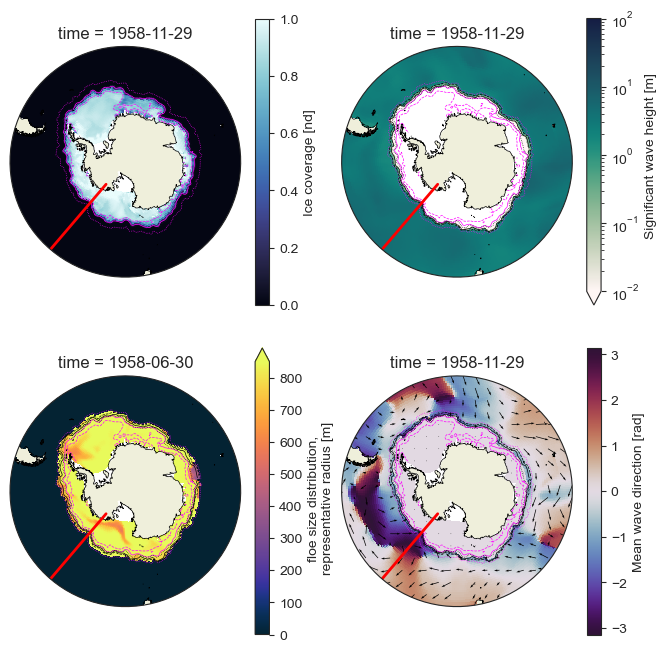

In [19]:
hemisphere = "south"
time_idx = 180
nx_idx = 140

# Slice time
ds_plot = ds_ww3.isel(time=time_idx)
time = ds_plot.time
# ds_plot_cice = ds_cice.sel(time=time, method="nearest")
ds_plot_cice = ds_cice.isel(time=time_idx)
# Setup polar projection
proj = ccrs.SouthPolarStereo()
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


# ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
#                       # cmap=settings.get("cmap"),
#                       # vmin=settings.get("vmin"),
#                       # vmax=settings.get("vmax"),
#                     cmap=cmo.tempo,
#                     transform=ccrs.PlateCarree(),
# ) 

ds_plot["HS"].plot(
    ax=axes[1],
    x="lon",
    y="lat",
    cmap=cmo.tempo,
    norm=mcolors.LogNorm(vmin=1e-2, vmax=100),
    transform=ccrs.PlateCarree(),
)

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

if (ATTEN_OPT == "IC4M2") or (ATTEN_OPT == "IC4M6"):
    settings = get_plot_settings("fsdrad")
    ds_plot_cice["fsdrad"].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
    ) 
else:
    ds_plot["ICEF"].plot(ax=axes[2], x="lon", y="lat", 
                          # cmap=settings.get("cmap"),
                          # vmin=settings.get("vmin"),
                          # vmax=settings.get("vmax"),
                        cmap=cmo.tempo,
                        transform=ccrs.PlateCarree(),
    ) 

cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values #- np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.cos(theta_rad)  # x-component
V = arrow_mag * np.sin(theta_rad)  # y-component

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 5  # plot every 5th point
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

# Overlay quivers
axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
               transform=ccrs.PlateCarree(),
               scale=100, regrid_shape=20, color='k')

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()

In [20]:
import numpy as np
import xarray as xr

# Extract the relevant variables at this time step
THM = ds_plot["THM"]
ICE = ds_plot["ICE"]

# Compute mean absolute direction error (how close to 0 rad)
mean_dir_error = np.abs(THM).mean(dim="ny")

# Compute mean sea ice concentration along the transect
mean_ice = ICE.mean(dim="ny")

# Normalise both metrics to 0–1 range
norm_dir = (mean_dir_error - mean_dir_error.min()) / (mean_dir_error.max() - mean_dir_error.min())
norm_ice = (mean_ice - mean_ice.min()) / (mean_ice.max() - mean_ice.min())

# Compute a combined score: prefer small direction error and high ice
# e.g. weighted 70% direction, 30% ice coverage
score = (1 - norm_dir) * 0.7 + norm_ice * 0.3

best_nx = score.argmax().values
print(f"Suggested transect nx = {best_nx}")

Suggested transect nx = 312


### Regional plot

In [21]:
# print(ds_ww3['lon'].isel(nx=nx_idx)[0].values)

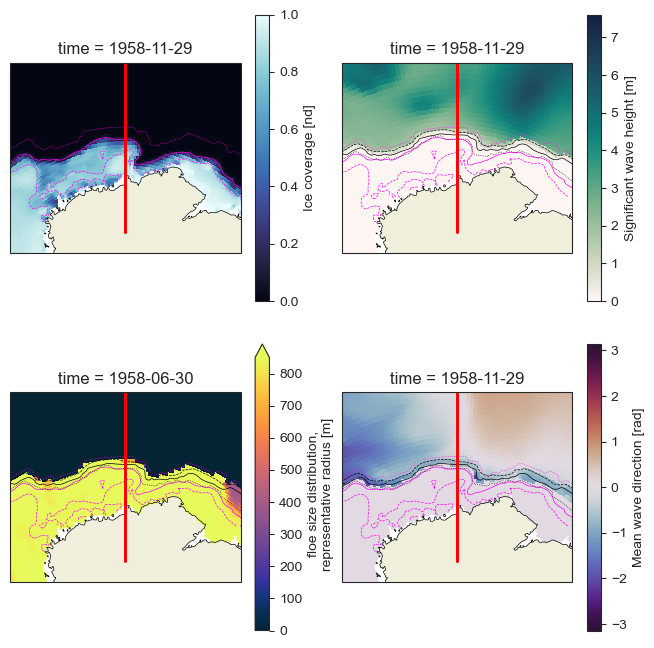

In [22]:
# region_extent = [30, 60, -72, -55]
nx_idx = best_nx
region_extent = [ds_ww3['lon'].isel(nx=nx_idx)[0].values-30, 
                 ds_ww3['lon'].isel(nx=nx_idx)[0].values+30, 
                 -80, 
                 -50]

# PLOT FOR A REGION
hemisphere = "regional"
shape = "rectangular"
# Slice time
ds_plot = ds_ww3.isel(time=time_idx)

# Setup polar projection
proj = proj = ccrs.Stereographic(central_latitude=(region_extent[2] + region_extent[3])/2, 
                                 central_longitude=(region_extent[0] + region_extent[1])/2)
dims = [2,2]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere, projection=proj, shape=shape)

# Plot ICE on the map
settings = get_plot_settings("ICE")

ds_plot["ICE"].plot(ax=axes[0], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot, hemisphere, projection)


ds_plot["HS"].plot(ax=axes[1], x="lon", y="lat", 
                      # cmap=settings.get("cmap"),
                      # vmin=settings.get("vmin"),
                      # vmax=settings.get("vmax"),
                    cmap=cmo.tempo,
                    transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[1], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[1], ds_plot, hemisphere, projection)

if (ATTEN_OPT == "IC4M2") or (ATTEN_OPT == "IC4M6"):
    settings = get_plot_settings("fsdrad")
    ds_plot_cice["fsdrad"].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
    ) 
else:
    ds_plot["ICEF"].plot(ax=axes[2], x="lon", y="lat", 
                          # cmap=settings.get("cmap"),
                          # vmin=settings.get("vmin"),
                          # vmax=settings.get("vmax"),
                        cmap=cmo.tempo,
                        transform=ccrs.PlateCarree(),
    ) 
cs = add_ice_contours(axes[2], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[2], ds_plot, hemisphere, projection)

# zero degrees representing waves coming from the north
theta_rad = ds_plot["THM"].values # - np.pi #𝜋 # We subtract pi so that 
arrow_mag = ds_plot["HS"].values
U = arrow_mag * np.cos(theta_rad)  # x-component (longitude)
V = arrow_mag * np.sin(theta_rad)  # y-component (latitude)

# Subsample the data for plotting arrows (too many arrows can clutter the plot)
stride = 2  # plot every 5th point
lon_quiver = ds_plot['lon'].values[::stride, ::stride]
lat_quiver = ds_plot['lat'].values[::stride, ::stride]
U_quiver = U[::stride, ::stride]
V_quiver = V[::stride, ::stride]

# Plot background mean direction
ds_plot["THM"].plot(ax=axes[3], x="lon", y="lat", 
                    cmap='twilight_shifted',
                    transform=ccrs.PlateCarree()
)

# # Overlay quivers
# axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
#                transform=ccrs.PlateCarree(),
#                scale=100, regrid_shape=20, color='k')

# # Compute propagation direction
# theta_rad = ds_plot["THM"].values
# theta_prop = theta_rad + np.pi
# arrow_mag = ds_plot["HS"].values
# U = arrow_mag * np.cos(theta_prop)
# V = arrow_mag * np.sin(theta_prop)

# # Meshgrid for lon/lat
# lon2d, lat2d = np.meshgrid(ds_plot['lon'].values, ds_plot['lat'].values)
# stride = 2
# lon_quiver = lon2d[::stride, ::stride]
# lat_quiver = lat2d[::stride, ::stride]
# U_quiver = U[::stride, ::stride]
# V_quiver = V[::stride, ::stride]

# # Plot quivers
# axes[3].quiver(lon_quiver, lat_quiver, U_quiver, V_quiver,
#                transform=ccrs.PlateCarree(),
#                scale=1, width=0.003, color='k', zorder=10)

cs = add_ice_contours(axes[3], ds_plot, hemisphere, projection)
cs2 = add_swh_contours(axes[3], ds_plot, hemisphere, projection)

# # Add coastlines and grid
# ax.coastlines()
# ax.gridlines(draw_labels=False, linestyle="--", alpha=0.5)

# --- Add red line at nx_idx ---
# If nx is an index along longitude:
lats = ds_plot["lat"].isel(nx=nx_idx)
lons = ds_plot["lon"].isel(nx=nx_idx)

for ax in axes:
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )
    # ax.legend()

# plt.legend()
# plt.show()
# Define your region bounds (lon_min, lon_max, lat_min, lat_max)


for ax in axes:
    # Limit to your region in PlateCarree
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    
    # Add red line at nx_idx
    ax.plot(
        lons, lats,
        color="red",
        linewidth=2,
        transform=ccrs.PlateCarree(),
        label=f"nx={nx_idx}"
    )

t = ds_plot['time']
t_str = np.datetime_as_string(t, unit='D').replace('-', '')
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/regional_basic_plot_{EXPT}_{t_str}.png", dpi=600)
plt.show()

In [23]:
ATTEN_OPT

'IC4M2'

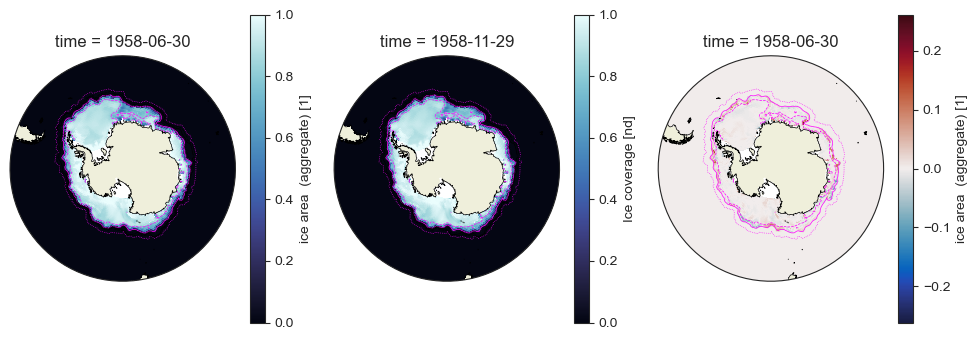

In [24]:
ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

var = 'aice'

proj = ccrs.SouthPolarStereo()
dims = [1,3]
fig, axes, projection = basic_axis(dims)

settings = get_plot_settings(var)

ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

ds_plot_ww3 = ds_ww3.isel(time=time_idx)
ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
ds_plot_cice[f'diff_{var}'].values = difference
# xr_diff = (ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var]).compute()
ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=cmo.balance,
                        # vmin=settings.get("vmin"),
                        # vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

cs = add_ice_contours(axes[0], ds_plot_cice, hemisphere, projection)
cs = add_swh_contours(axes[0], ds_plot_ww3, hemisphere, projection)

cs = add_ice_contours(axes[1], ds_plot_cice, hemisphere, projection)
cs = add_swh_contours(axes[1], ds_plot_ww3, hemisphere, projection)

cs = add_ice_contours(axes[2], ds_plot_cice, hemisphere, projection)


In [25]:
 # xr_diff = (ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var]).compute()

In [39]:
ds_ww3['HS'].where(ds_ww3['ICEH'] > 0.25).max().values

array(10.803448, dtype=float32)

In [41]:
ds_ww3['HS'].where(ds_ww3['ICE'] > 0.2).max().values

array(1.4253374e-07, dtype=float32)

In [44]:
ds_ww3['ICE'].where(ds_ww3['HS'] < 1e-12).min().values

array(3.895964e-06, dtype=float32)

In [46]:
ds_ww3['ICEH'].where(ds_ww3['HS'] < 1e-12).min().values

array(0.2, dtype=float32)

In [51]:
def find_ice_edge(ds, time_idx, nx_idx, ny_slice, var='ICE', threshold=0.15):
    """
    Find the northernmost grid cell where sea ice concentration exceeds a threshold.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing sea ice concentration (e.g., ds_ww3).
    time_idx : int
        Time index for selection.
    nx_idx : int
        Zonal index for selection.
    ny_slice : slice
        Meridional slice over which to search.
    var : str, optional
        Variable name for ice concentration. Default is 'ICE'.
    threshold : float, optional
        Threshold for defining the ice edge. Default is 0.15.

    Returns
    -------
    ny_index : int
        Index along 'ny' of the northernmost cell where ICE exceeds the threshold.
    ny_value : float
        Coordinate value corresponding to that index (e.g., latitude).
    """

    ice_line = ds[var].isel(time=time_idx, nx=nx_idx, ny=ny_slice)

    # Determine if ny increases northward
    ny_coords = ice_line['ny']
    lat_values = ds['lat'].isel(nx=nx_idx, ny=ny_slice)
    increasing_northward = lat_values.values[-1] > lat_values.values[0]

    # Boolean mask of where ICE > threshold
    mask = ice_line > threshold

    # Choose index based on latitude direction
    if increasing_northward:
        idx = np.where(mask)[0].max() if mask.any() else None
    else:
        idx = np.where(mask)[0].min() if mask.any() else None

    if idx is None:
        return None, None  # no grid cell exceeds threshold

    ny_index = ice_line.ny[idx].item()
    ny_value = lat_values.isel(ny=idx).item()

    return ny_index, ny_value

ny_slice = slice(0,100)
ice_edge_idx, ice_edge_lat = find_ice_edge(ds_ww3, time_idx=time_idx, nx_idx=nx_idx, ny_slice=ny_slice)
p01_ice_edge_idx, puny_ice_edge_lat = find_ice_edge(ds_ww3, time_idx=time_idx, nx_idx=nx_idx, ny_slice=ny_slice, threshold=0.01)
puny_ice_edge_idx, puny_ice_edge_lat = find_ice_edge(ds_ww3, time_idx=time_idx, nx_idx=nx_idx, ny_slice=ny_slice, threshold=PUNY)
print(f"Ice edge found at ny={ice_edge_idx}, latitude={ice_edge_lat:.2f}°")

Ice edge found at ny=38, latitude=-63.23°


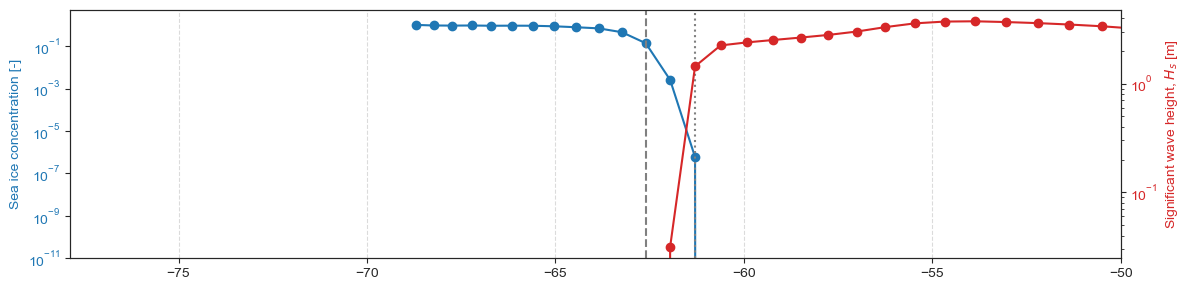

In [52]:
fig, ax1 = plt.subplots(1,1, figsize=(12,3))

# Extract transect
ds_transect = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)

# Use latitude for x-axis
x_vals = ds_transect["lat"].values

# First variable: ICE
ax1.plot(x_vals, ds_transect["ICE"].values, color="tab:blue", label="ICE", marker='o')
ax1.set_ylabel("Sea ice concentration [-]", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(PUNY, 5)
ax1.set_yscale('log')

# Second variable: HS (on twin axis)
ax2 = ax1.twinx()
ax2.plot(x_vals, ds_transect["HS"].values, color="tab:red", label="HS", marker='o')
ax2.set_ylabel("Significant wave height, $H_s$ [m]", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_yscale('log')

# Grid lines
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.7)

# Mark ice edges
# ax1.axvline(ds_transect["lat"].values[ice_edge_idx], color='gray', linestyle='-')
ax1.axvline(ds_transect["lat"].values[p01_ice_edge_idx], color='gray', linestyle='--')
ax1.axvline(ds_transect["lat"].values[puny_ice_edge_idx], color='gray', linestyle=':')

ax1.set_xlim([x_vals.min(), -50])

plt.tight_layout()
plt.show()

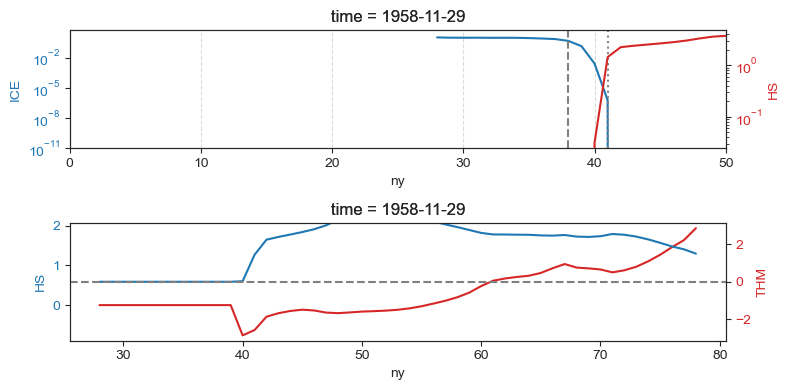

In [53]:
fig, axes = plt.subplots(2,1, figsize=(8,4))

ax1 = axes[0]

ds_transect = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)
# First variable: ICE
ds_transect["ICE"].plot(ax=ax1, color="tab:blue", label="ICE")
ax1.set_ylabel("ICE", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(PUNY, 5)

# Second variable: HS (on twin axis)
ax2 = ax1.twinx()
ds_transect["HS"].plot(ax=ax2, color="tab:red", label="HS")
ax2.set_ylabel("HS", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1_bottom = axes[1]
ds_transect["THM"].plot(ax=ax1_bottom, color="tab:red", label="THM")
ax1_bottom.set_ylabel("HS", color="tab:blue")
ax1_bottom.tick_params(axis="y", labelcolor="tab:blue")

# Second variable: HS (on twin axis)
ax2_bottom = ax1_bottom.twinx()
ds_transect["HS"].plot(ax=ax2_bottom, color="tab:blue", label="HS")
ax2_bottom.set_ylabel("THM", color="tab:red")
ax2_bottom.tick_params(axis="y", labelcolor="tab:red")

ax2_bottom.set_ylim((-np.pi, np.pi))
ax2_bottom.axhline(0, linestyle='--', color='gray')

x_vals = ds_ww3["nx"].values

# Add grid lines at those tick positions
ax1.grid(True, which="both", axis="x", linestyle="--", alpha=0.7)

ax1.axvline(ice_edge_idx, color='gray', linestyle ='--')
ax1.axvline(puny_ice_edge_idx, color='gray', linestyle =':')

ax1.set_xlim([0,50])

plt.tight_layout()
plt.show()

In [54]:
# ds_ww3["THM"].isel(time=time_idx, nx=nx_idx).plot()

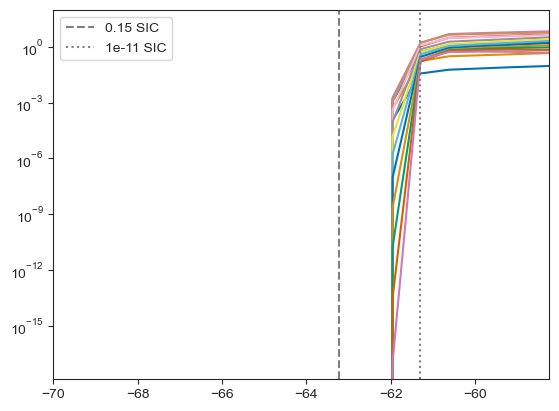

In [55]:
ds_plot = ds_ww3.isel(time=time_idx, nx=nx_idx, ny=ny_slice)
for freq in ds_ww3['EF'].freq.isel(freq=slice(5,-5)):
    plt.plot(ds_plot['lat'], ds_plot['EF'].sel(freq=freq))

plt.axvline(ds_plot['lat'].isel(ny=ice_edge_idx), color='gray', linestyle ='--', label='0.15 SIC')
plt.axvline(ds_plot['lat'].isel(ny=puny_ice_edge_idx), color='gray', linestyle =':', label='1e-11 SIC')
plt.xlim(-70,ds_plot['lat'].isel(ny=ice_edge_idx)+5)
plt.yscale('log')
plt.legend()

In [56]:
ice_edge_lat = ds_plot['lat'].isel(ny=ice_edge_idx) + 2.5

ds_wave_in_ice = ds_plot.where(ds_plot['lat']< ice_edge_lat).where(ds_plot['HS']>1e-7).dropna(dim="ny", how="all").compute()
ds_wave_in_ice

<xarray.Dataset> Size: 280B
Dimensions:  (ny: 2, freq: 25)
Coordinates:
    time     datetime64[ns] 8B 1958-11-29
    lon      (ny) float64 16B 32.5 32.5
    lat      (ny) float64 16B -61.96 -61.29
Dimensions without coordinates: ny, freq
Data variables:
    HS       (ny) float32 8B 0.0314 1.44
    ICE      (ny) float32 8B 0.00255 5.866e-07
    ICEF     (ny) float32 8B 1e+03 1e+03
    THM      (ny) float32 8B -0.7605 -0.6269
    EF       (freq, ny) float32 200B 5.281e-07 0.000545 ... 0.0 0.04827
    ICEH     (ny) float32 8B 0.2 0.2
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'THM', 'E...
    intake_esm_attrs:file_id:                 wave.fx.freq:25.nx:360.ny:300
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                EF,FP0,HS,ICE,ICEF,ICEH,T01,T02...
    intake_esm_attrs:variable_long_name:      1D spectral density,Peak freque...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          m2 s,s-1,m,nd,m,m,s,s,s,rad,m s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   wave.fx.freq:25.nx:360.ny:300

### Estimate the rate of attenuation
We calculate the empirical attenuation rate by completing a log regression
$$
    \frac{1}{a_{\text{ice}}} \log \left( \frac{S_{\text{ice}} (x; f)}{S_0(x; f)} \right) \sim -\alpha_a  x
$$ which returns the *apparent attenuation*, $\alpha_a$, over distance, $x$.

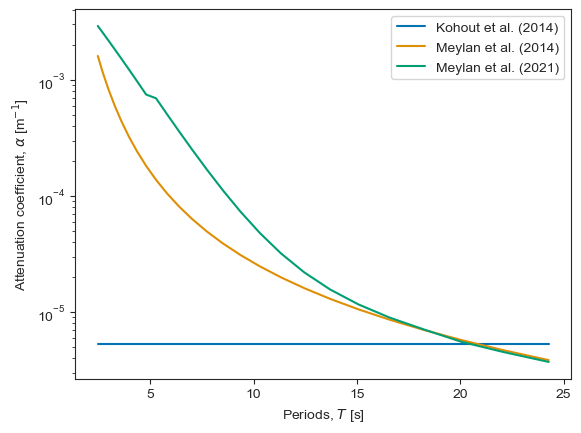

In [57]:
# Parameters from SPECTRUM_NML
freqs, periods = get_ww3_freqs(nk=25)

Hs_init = ds_wave_in_ice['HS'].max()
thickness = ds_wave_in_ice['ICEH'].max()
floeDiameter = ds_wave_in_ice['ICEF'].max()

α_kohout = kohout_2014_attenuation(Hs_init=1.0)
α_mbk = mbk_2014_attenuation(periods)
α_meylan, _ = meylan_2021_attenuation(periods, thickness, floeDiameter)

α_kohout_period = np.array([kohout_2014_attenuation(Hs_init=1.0) for T in periods])
plt.plot(periods, α_kohout_period, label='Kohout et al. (2014)')
plt.plot(periods, α_mbk, label='Meylan et al. (2014)')
plt.plot(periods, α_meylan, label='Meylan et al. (2021)')
plt.legend()
plt.xlabel('Periods, $T$ [s]')
plt.ylabel('Attenuation coefficient, $\\alpha$ [m$^{-1}$]')
plt.yscale('log')

In [58]:
freqs

array([0.04118   , 0.045298  , 0.0498278 , 0.05481058, 0.06029164,
       0.0663208 , 0.07295288, 0.08024817, 0.08827299, 0.09710029,
       0.10681031, 0.11749135, 0.12924048, 0.14216453, 0.15638098,
       0.17201908, 0.18922099, 0.20814309, 0.22895739, 0.25185313,
       0.27703845, 0.30474229, 0.33521652, 0.36873817, 0.40561199])

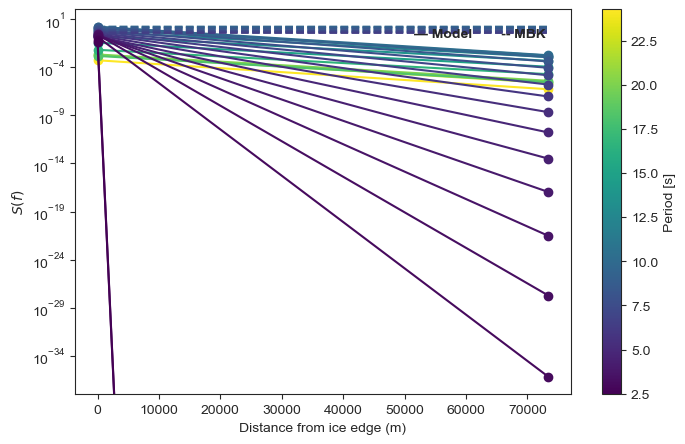

In [59]:



# --- Meylan et al. (2014) parameterisation ---
a = 2.2e-3
b = 4.59e-2
alpha_MBK = a/periods**2 + b/periods**4

def propagate_waves_MBK(ds_wave_in_ice, distance_into_ice, atten_coeff):
    distance = distance_into_ice.sortby(distance_into_ice)
    aice = ds_wave_in_ice['ICE'].sortby(distance_into_ice)
    initial_spectrum = ds_wave_in_ice['EF'].max()
    propagated_spectrum = initial_spectrum * np.exp(- aice * atten_coeff * distance)
    return propagated_spectrum


distance_into_ice = abs((ds_wave_in_ice['lat'] - ds_wave_in_ice['lat'].max())*111*1e3) # Degrees latitude to m

# Select frequencies
ds_freqs = ds_wave_in_ice.freq.isel(freq=slice(10,-10))

# Set up colormap
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=periods.min().item(), vmax=periods.max().item())

fig, ax = plt.subplots(figsize=(8,5))

for i_freq, period in enumerate(periods):
    color = cmap(norm(period))
    
    # Original spectrum
    ax.plot(distance_into_ice, ds_wave_in_ice['EF'].sel(freq=i_freq), 
            color=color, marker='o', linestyle='-')
    
    # Propagated spectrum
    if (ds_wave_in_ice['EF'].sel(freq=i_freq) > 0.3).any():
        propagated_spectrum = propagate_waves_MBK(
            ds_wave_in_ice.sel(freq=i_freq), distance_into_ice, alpha_MBK[i_freq] # or alpha_MBK[freq]
        )
        ax.plot(distance_into_ice.sortby(distance_into_ice),
                propagated_spectrum, linestyle='--', color=color)


# Labels
ax.set_xlabel('Distance from ice edge (m)')
ax.set_ylabel('$S(f)$')
ax.text(
    0.8, 0.95, "— Model",        # position in axes coords
    transform=ax.transAxes,             # use axes coordinates (0–1 range)
    ha='right', va='top',  fontweight='bold'             # align right/top
)
ax.text(
    0.95, 0.95, "-- MBK",        # position in axes coords
    transform=ax.transAxes,             # use axes coordinates (0–1 range)
    ha='right', va='top',   fontweight='bold'            # align right/top
)
# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Period [s]')

plt.yscale('log')

plt.show()

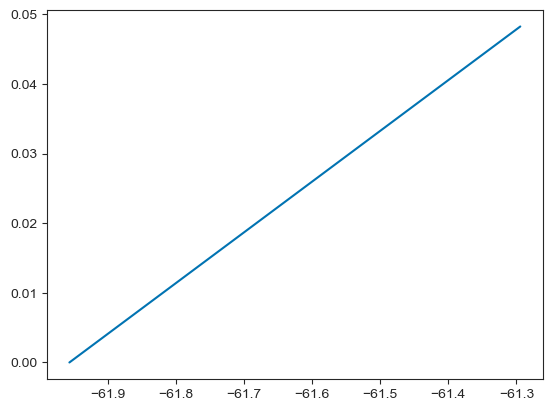

In [60]:
plt.plot(ds_wave_in_ice['lat'], ds_wave_in_ice['EF'].sel(freq=i_freq))

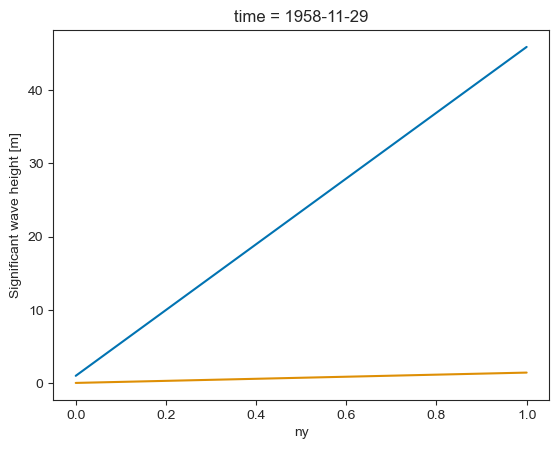

In [61]:
# x = distance_into_ice
# y = ds_wave_in_ice['EF'].sel(freq=freq)
# distance_into_ice

# ds_wave_in_ice['EF'].min()
Hs_norm = ds_wave_in_ice['HS']/ds_wave_in_ice['HS'].values[0]
a_ice = ds_wave_in_ice['ICE'].values
y = - np.log(Hs_norm) #/ a_ice
np.exp(-y).plot()

ds_wave_in_ice['HS'].plot()

Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data
Not enough data


/jobfs/152939565.gadi-pbs/ipykernel_2067867/2157601989.py:9: RuntimeWarning: divide by zero encountered in divide
  S_norm = ds_in['EF'].sel(freq=freq).values/ S_init
/jobfs/152939565.gadi-pbs/ipykernel_2067867/2157601989.py:9: RuntimeWarning: invalid value encountered in divide
  S_norm = ds_in['EF'].sel(freq=freq).values/ S_init


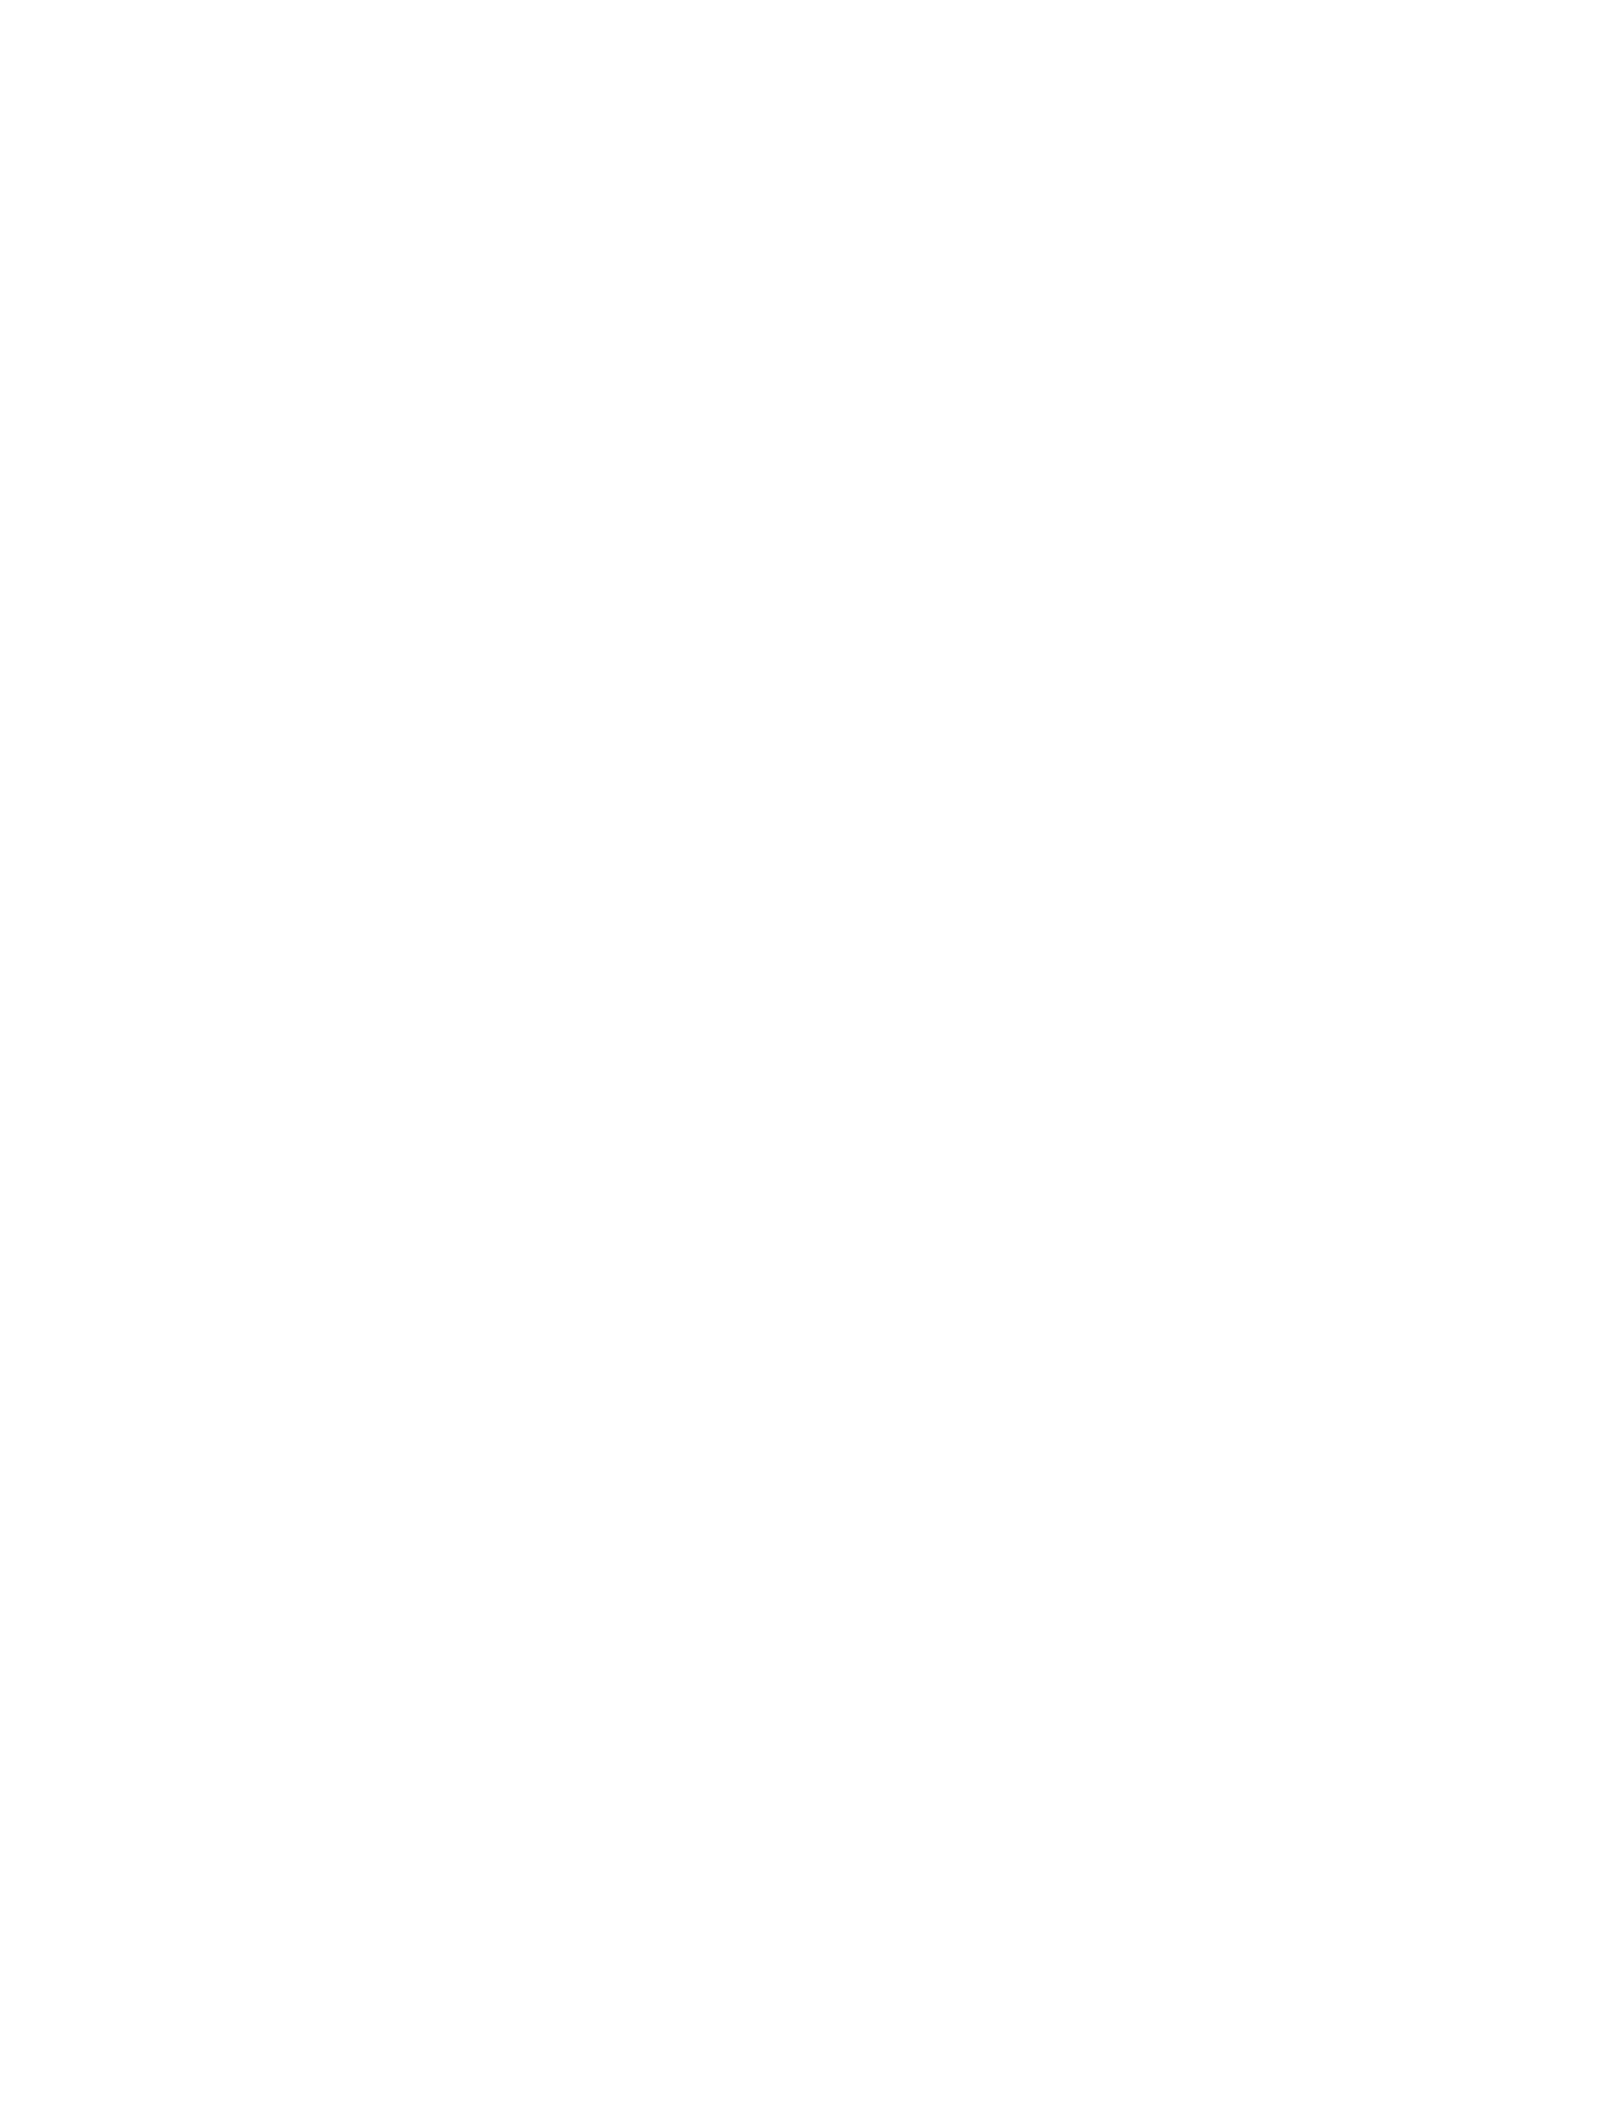

In [62]:
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM

def plot_and_calculate_log_reg(ds_in, distance_from_edge, freq, ax=None):
    # --- Your data ---
    x = distance_from_edge.values
    S_init = ds_in['EF'].sel(freq=freq).values[0]
    S_norm = ds_in['EF'].sel(freq=freq).values/ S_init
    a_ice = ds_in['ICE'].values
    y = np.log(S_norm) #/ a_ice
    
    # Mask: finite values, x > 0, EF > 1e-11
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (ds_in['EF'].sel(freq=freq).values > 1e-12) & (ds_in['ICE'].values > PUNY)
    x = x[mask]
    y = y[mask]
    
    if len(x) < 2:  # not enough points to fit
        print("Not enough data")
        return None, None

    # Limit to at most 7 points
    max_datapoints = 5
    if len(x) > max_datapoints:
        x = x[:max_datapoints]
        y = y[:max_datapoints]

    x = x - x.min()

    # --- Prepare design matrix for simple regression ---
    X = x
    X = sm.add_constant(X)  # adds intercept term

    # --- Ordinary Least Squares regression ---
    model = sm.OLS(y, X).fit()
    beta0, beta1 = model.params
    alpha = -beta1  

    # --- Predictions for plotting ---
    x_fit = x #np.linspace(x.min(), x.max(), 200)
    X_fit = sm.add_constant(x_fit)
    y_fit = model.predict(X_fit)

    if model.rsquared < 0.5:
        print(f"Poor fit (R² = {model.rsquared:.2f}) for freq={float(periods[freq]):.3f} s")
        return None, None

    # --- Plot ---
    if ax is not None:
        ax.scatter(x, y, label="Data", s=10)
        ax.plot(x_fit, y_fit, color="red", lw=1.5,
                label=f"y = {beta0:.2e} + {beta1:.2e} x")
        ax.set_title(f"Freq = {float(freq):.3f} Hz")
        ax.set_xlabel("Distance into ice [m]")
        ax.set_ylabel("log(E(f))$  [m$^2$ s]")
        ax.legend(fontsize=8)

    return beta0, alpha


# --- Loop over all freqs and create subplots ---
freqs = ds_wave_in_ice.freq.values
n_freqs = len(freqs)

ncols = 4  # choose how many per row
nrows = int(np.ceil(n_freqs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), constrained_layout=True)
axes = axes.flatten()

alphas = []
intercepts = []

for i, freq in enumerate(freqs):
    intercept, alpha = plot_and_calculate_log_reg(
        ds_wave_in_ice,
        distance_into_ice,
        freq, 
        ax=axes[i]
    )
    if intercept is None:  # no valid data
        axes[i].axis("off")
    intercepts.append(intercept)
    alphas.append(alpha)

# Hide any unused subplot slots (after last frequency)
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM


import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.robust.robust_linear_model import RLM

def plot_and_calculate_log_reg(ds_in, distance_from_edge, idx_freq, freq, ax=None, min_points=2):
    """
    Fit OLS and robust regression for wave energy attenuation.
    Adds flag if not enough valid data points are available.
    """

    # --- Extract data ---
    x = distance_from_edge.values
    # y = ds_in["EF"].sel(freq=freq).values[0, :]
    S_init = ds_in['EF'].sel(freq=idx_freq).values[0]
    S_norm = ds_in['EF'].sel(freq=idx_freq).values/ S_init
    y = S_norm
    # Remove NaNs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    # Initialize outputs
    results = {
        "freq_idx": idx_freq.item() if hasattr(idx_freq, "item") else idx_freq,
        "freq": freq.item() if hasattr(freq, "item") else freq,
        "alpha_ols": np.nan,
        "rsq_ols": np.nan,
        "alpha_rlm": np.nan,
        "rsq_rlm": np.nan,
        "enough_data": True
    }

    # --- Check data sufficiency ---
    if len(x) < min_points:
        results["enough_data"] = False
        print(f"⚠️ Not enough data points for freq={freq} Hz: only {len(x)} available.")
        return results

    # --- Transform (log-linear fit) ---
    y_log = np.log(y)

    # --- OLS fit ---
    X = sm.add_constant(x)
    ols_model = sm.OLS(y_log, X).fit()
    alpha_ols = -ols_model.params[1]
    rsq_ols = ols_model.rsquared

    # --- Robust fit (RLM) ---
    rlm_model = RLM(y_log, X, M=sm.robust.norms.HuberT()).fit()
    alpha_rlm = -rlm_model.params[1]
    rsq_rlm = 1 - np.sum(rlm_model.resid ** 2) / np.sum((y_log - np.mean(y_log)) ** 2)

    # --- Store results ---
    results.update({
        "alpha_ols": alpha_ols,
        "rsq_ols": rsq_ols,
        "alpha_rlm": alpha_rlm,
        "rsq_rlm": rsq_rlm
    })

    # --- Optional plotting ---
    if ax is not None:
        x_fit = np.linspace(np.nanmin(x), np.nanmax(x), 100)
        y_fit_ols = np.exp(ols_model.predict(sm.add_constant(x_fit)))
        y_fit_rlm = np.exp(rlm_model.predict(sm.add_constant(x_fit)))

        ax.plot(x, y, "o", label=f"{freq:.3f} Hz data")
        ax.plot(x_fit, y_fit_ols, "r--", label="OLS fit")
        ax.plot(x_fit, y_fit_rlm, "g-", label="RLM fit")
        ax.set_yscale("log")
        ax.legend()

    return results


# --- Loop over all frequencies ---
# freqs = ds_wave_in_ice.freq.values
n_freqs = len(freqs)
ncols = 4
nrows = int(np.ceil(n_freqs / ncols))
# fig, axes = plt.subplots(
#     nrows, ncols, figsize=(4 * ncols, 3 * nrows), constrained_layout=True
# )
# axes = axes.flatten()

results = []
for i, freq in enumerate(freqs):
    res = plot_and_calculate_log_reg(
        ds_wave_in_ice,
        distance_into_ice,
        i,
        freq,
        ax=None, #axes[i],
        # min_energy_ratio=1e-12,
        # max_distance_m=150e3,
        # puny=PUNY,
    )
    if res is None:
        print("No result")
        # axes[i].axis("off")
    else:
        results.append(res)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.show()

# --- Summarise results ---
import pandas as pd

df = pd.DataFrame(results)

# Scatter comparison of α_RLM vs α_OLS
plt.figure(figsize=(5, 5))
plt.scatter(df["alpha_ols"], df["alpha_rlm"], c=df["rsq_rlm"], cmap="viridis", s=40)
plt.plot([0, np.nanmax(df["alpha_ols"])], [0, np.nanmax(df["alpha_rlm"])], "k--")
plt.xlabel("α (OLS) [m⁻¹]")
plt.ylabel("α (RLM) [m⁻¹]")
plt.title("Comparison of OLS vs Robust Regression")
plt.colorbar(label="R² (RLM)")
plt.grid(True)
plt.tight_layout()
plt.show()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid


ZeroDivisionError: float division by zero

In [ ]:
plt.plot(df['freq'], df['alpha_ols'])
plt.plot(df['freq'], df['alpha_rlm'])

In [ ]:
# Parameters from SPECTRUM_NML
f1 = 0.04118   # lowest frequency [Hz]
xfr = 1.1      # frequency growth factor
nk = 25        # number of frequency bins

# Compute frequency bins
freqs = f1 * xfr**np.arange(nk)
periods = 1.0 / freqs  # convert to periods

# --- Compute which frequencies have sufficient energy ---
valid_mask = []

for ifreq, freq in enumerate(freqs):
    EF_vals = ds_wave_in_ice['EF'].sel(freq=ifreq).values
    if np.nanmax(EF_vals) > PUNY:
        valid_mask.append(True)
    else:
        valid_mask.append(False)

valid_mask = np.array(valid_mask)

# Apply mask to alphas and periods
periods_valid = periods[valid_mask]
alphas_valid = np.array(alphas)[valid_mask]

# --- Plot observed attenuation ---
plt.plot(periods_valid, alphas_valid, 'o-', label=f"{EXPT[4:9]} fit")



# --- Plot IC4M6 Step function ---
# Input parameters (from your namelist)
IC4KI = np.array([0.05e-12, 0.07e-12, 0.15e-12, 1.00e-04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
IC4FC = np.array([0.100, 0.120, 0.160, 99.00, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Define frequency array (0–1 Hz)
freq_tmp = np.linspace(0.05, 1.0, 500)
ki = np.zeros_like(freq_tmp)

# Step function: select correct KI for each frequency
for i, f in enumerate(freq_tmp):
    for j in range(len(IC4FC)):
        if f < IC4FC[j]:
            ki[i] = IC4KI[j]
            break

plt.step(1/freq_tmp, ki, where='post', linewidth=1.5, label="Modified IC4M6")


# Aesthetics
plt.xlabel('Period $T$ [s]')
plt.ylabel('Attenuation coefficient $\\alpha (f)$')

plt.plot(periods, alpha_MBK, '-', label="IC4M2 (True)")

plt.yscale('log')

plt.legend()
plt.show()

In [ ]:


# Print nicely
# for i, (f, T) in enumerate(zip(freqs, periods), start=1):
    # print(f"Bin {i:2d}: {f:.5f} Hz  ({T:.2f} s)")

plt.plot(periods, alphas)
plt.xlabel('Frequency, $f$ [s$^{-1}$]')
plt.ylabel('Attenuation coefficient, $\\alpha (f)$')

# Meylan et al. (2014)

a = 2.2*10**-3
b = 4.59*10**-2
alpha_MBK = a/periods**2 + b/periods**4
alpha_MBK

plt.plot(periods, alpha_MBK)

In [ ]:
# ds_tmp = xr.open_dataset('/scratch/ps29/nd0349/access-om3/work/wav_config_iaf_tune/access-om3.ww3.hi.1958-02-28-00000.nc')
# ds_tmp
np.nanmin(ds_ww3['ICE'].isel(time=-1).values)

ds_ww3['ICE'].where(ds_ww3['ICE'] > 0).min().values
# alphas

In [ ]:
plt.plot(periods, ds_wave_in_ice['EF'].isel(ny=-6))
plt.plot(periods, ds_wave_in_ice['EF'].isel(ny=-7), linestyle='--')
plt.plot(periods, ds_wave_in_ice['EF'].isel(ny=-8), linestyle=':')
plt.yscale('log')

In [ ]:
client.close()